In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,precision_score,recall_score,f1_score
import joblib
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [135]:
#drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/project/customer_churn.csv"
df = pd.read_csv(dataset_path)
print("Original dataset :",df.shape)




Original dataset : (10000, 13)


In [136]:
print(df.head())

   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0  


In [137]:
df.drop("Surname", axis=1, inplace=True)
df.drop("CustomerId", axis=1, inplace=True)


In [126]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None


In [138]:
print(df.shape)

(10000, 11)


In [139]:
print("Missing value count:")
print(df.isnull().sum())


Missing value count:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [140]:
print("Duplicates count :",df.duplicated().sum())


Duplicates count : 0


In [141]:
print("Cleaned dataset",df.shape)


Cleaned dataset (10000, 11)


In [142]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None


In [143]:
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_columns = encoder.fit_transform(df[["Geography", "Gender"]])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(["Geography", "Gender"]))
df = df.drop(["Geography", "Gender"], axis=1)
df = pd.concat([df, encoded_df], axis=1)
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  float64
 10  Geography_Spain    10000 non-null  float64
 11  Gender_Male        10000 non-null  float64
dtypes: float64(5), int64(7)
memory usage: 937.6 KB
None


In [144]:
print("after encoding",df.shape)

after encoding (10000, 12)


In [145]:
# Handle outliers using IQR
outlier_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary"]


for col in outlier_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  df = df[(df[col] >= (Q1 - 2.5 * IQR)) & (df[col] <= (Q3 + 2.5 * IQR))]
print("Shape after outlier handling",df.shape)



Shape after outlier handling (9946, 12)


In [146]:
#Train-test split
X = df.drop(columns=['Exited'])
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
#scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [148]:
#check if the dataset is balanced
churn_counts = df["Exited"].value_counts()
print(churn_counts)

Exited
0    7910
1    2036
Name: count, dtype: int64


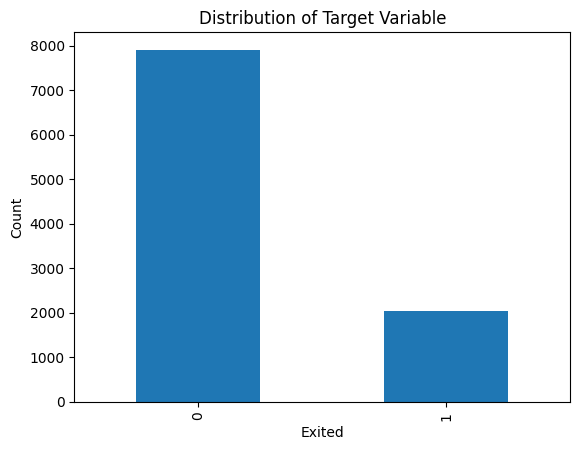

In [149]:
df['Exited'].value_counts().plot(kind='bar')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()


In [150]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
df = pd.DataFrame(X_resampled, columns=X.columns)
df["Exited"] = y_resampled  # Add the target variable



churn_counts = df["Exited"].value_counts()
print(churn_counts)
print("Balanced dataset shape:", df.shape)

Exited
1    7910
0    7910
Name: count, dtype: int64
Balanced dataset shape: (15820, 12)


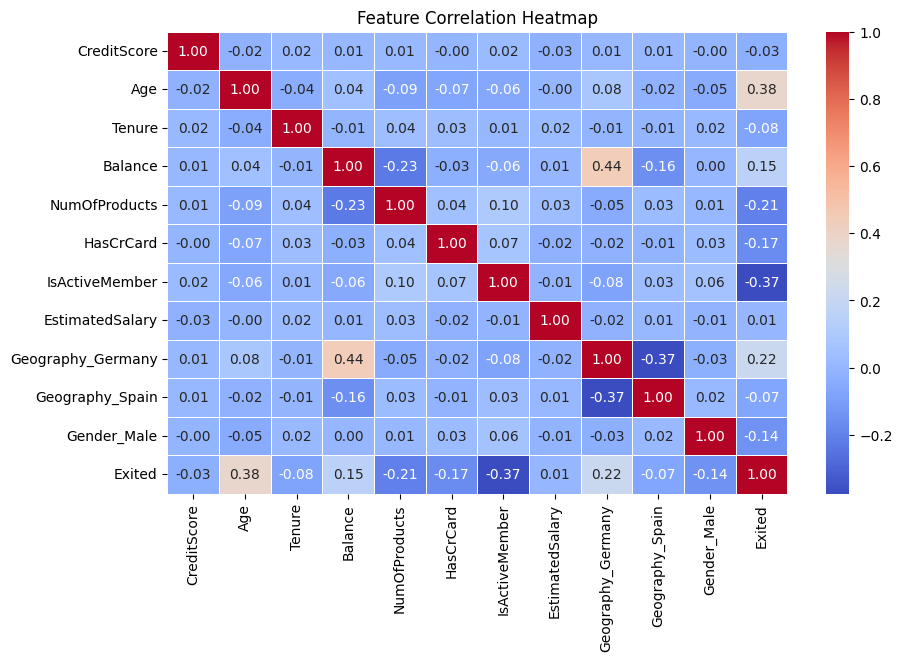

In [151]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

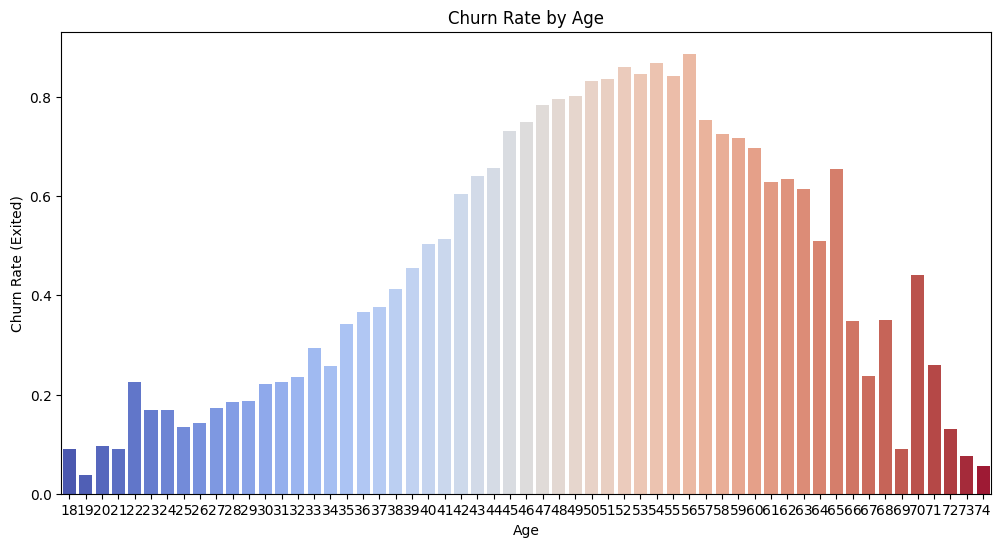

In [152]:
#Churn vs age
plt.figure(figsize=(12, 6))
sns.barplot(x=df["Age"], y=df["Exited"], errorbar=None, hue=df["Age"], palette="coolwarm", legend=False)
plt.xlabel("Age")
plt.ylabel("Churn Rate (Exited)")
plt.title("Churn Rate by Age")
plt.show()

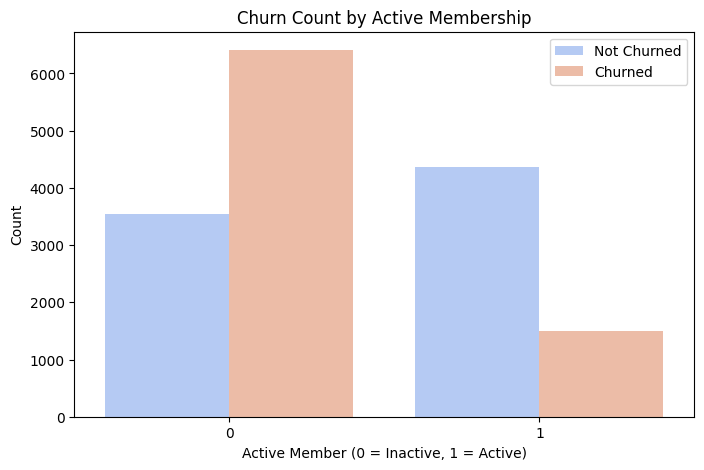

In [153]:

plt.figure(figsize=(8, 5))
sns.countplot(x="IsActiveMember", hue="Exited", data=df, palette="coolwarm")
plt.xlabel("Active Member (0 = Inactive, 1 = Active)")
plt.ylabel("Count")
plt.title("Churn Count by Active Membership")
plt.legend(["Not Churned", "Churned"])
plt.show()


In [154]:
#Random forest classifier
#  Hyperparameter Tuning

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [10, 15, 20],
    'class_weight': [{0: 1, 1: 2.0}, {0: 1, 1: 2.5}, {0: 1, 1: 3.0}]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=40),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='recall',
    n_jobs=-1,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 10, 'class_weight': {0: 1, 1: 3.0}}


In [155]:
#Random forest classifier
# Model Training


model = RandomForestClassifier( n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    random_state=40)
model.fit(X_train, y_train)




RandomForestClassifier(class_weight={0: 1, 1: 3.0}, max_depth=10,
                       min_samples_leaf=20, min_samples_split=20,
                       random_state=40)

In [156]:
#Random forest classifier
# Predictions
y_pred = model.predict(X_test)
result=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
print(result)


      Actual  Predicted
8819       0          0
6460       0          0
7936       0          0
9331       0          0
3363       0          0
...      ...        ...
9412       0          0
5369       1          1
453        0          1
5227       0          0
719        0          1

[1990 rows x 2 columns]


In [157]:
#Random forest classifier
#Evaluation

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1589
           1       0.58      0.65      0.61       401

    accuracy                           0.84      1990
   macro avg       0.75      0.77      0.75      1990
weighted avg       0.84      0.84      0.84      1990



In [158]:
#randomForestClassifier
#Evaluation
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1402  187]
 [ 141  260]]


In [159]:
#randomForestClassifier
#Evaluation
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 0.8592
Testing Accuracy: 0.8352


In [160]:
#LogisticRegression
# Model Training
model_two = LogisticRegression(class_weight="balanced", solver='saga', max_iter=5000,random_state=42)
model_two.fit(X_train_scaled, y_train)



LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42,
                   solver='saga')

In [88]:
#LogisticRegression
# Predictions
y_pred = model_two.predict(X_test_scaled)
result=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
print(result)


      Actual  Predicted
8819       0          0
6460       0          0
7936       0          0
9331       0          0
3363       0          1
...      ...        ...
9412       0          0
5369       1          1
453        0          1
5227       0          0
719        0          0

[1990 rows x 2 columns]


In [161]:
#LogisticRegression
#Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1589
           1       0.58      0.65      0.61       401

    accuracy                           0.84      1990
   macro avg       0.75      0.77      0.75      1990
weighted avg       0.84      0.84      0.84      1990



In [162]:
#LogisticRegression
#Evaluation
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1402  187]
 [ 141  260]]


In [163]:
#LogisticRegression
#Evaluation
train_acc = model_two.score(X_train, y_train)
test_acc = model_two.score(X_test, y_test)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 0.2061
Testing Accuracy: 0.2025


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [164]:
#XGBoostClassifier
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [3, 5, 7]
}


random_search = RandomizedSearchCV(XGBClassifier(random_state=42),param_distributions=param_grid, cv=5, scoring='f1')
random_search.fit(X_train, y_train)



best_params = random_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'scale_pos_weight': 3, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [165]:
#XGBoostClassifier
#Model Training
model_three = XGBClassifier(n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    scale_pos_weight=best_params['scale_pos_weight'],
    random_state=42)
model_three.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [166]:
# Predictions
y_pred = model_three.predict(X_test)
result=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
print(result)



      Actual  Predicted
8819       0          0
6460       0          0
7936       0          0
9331       0          0
3363       0          1
...      ...        ...
9412       0          0
5369       1          1
453        0          1
5227       0          0
719        0          1

[1990 rows x 2 columns]


In [167]:
# Evaluate model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1589
           1       0.57      0.66      0.61       401

    accuracy                           0.83      1990
   macro avg       0.74      0.77      0.75      1990
weighted avg       0.84      0.83      0.84      1990



In [168]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Confusion Matrix:
[[1392  197]
 [ 136  265]]


In [169]:
# Comparing 3 models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Model_Object": model

    }

#Evaluate Three Models
rf_results = evaluate_model(model, X_test, y_test, "Random Forest")
lr_results = evaluate_model(model_two, X_test, y_test, "Logistic Regression")
xgb_results = evaluate_model(model_three, X_test, y_test, "XGBoost")


results = [rf_results, lr_results, xgb_results]
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True))


                 Model  Accuracy  Precision    Recall  F1-Score  \
0        Random Forest  0.835176   0.581655  0.648379  0.613208   
1              XGBoost  0.827638   0.561441  0.660848  0.607102   
2  Logistic Regression  0.202513   0.201710  1.000000  0.335705   

                                        Model_Object  
0  (DecisionTreeClassifier(max_depth=10, max_feat...  
1  XGBClassifier(base_score=None, booster=None, c...  
2  LogisticRegression(class_weight='balanced', ma...  


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [170]:
best_model_info = max([rf_results, lr_results, xgb_results], key=lambda x: x["F1-Score"])
best_model = best_model_info["Model_Object"]
print(best_model)


RandomForestClassifier(class_weight={0: 1, 1: 3.0}, max_depth=10,
                       min_samples_leaf=20, min_samples_split=20,
                       random_state=40)


In [171]:
joblib.dump(best_model, "churn_model.pkl")


['churn_model.pkl']

In [172]:
#New predictions
new_data=[
    [700, 35, 5, 12000.0, 2, 1, 1, 50000.0, 1, 0, 1],
    [480, 55, 1, 80000.0, 1, 0, 0, 20000.0, 0, 1, 0],
    [720, 29, 6, 0.0, 2, 1, 1, 80000.0, 0, 0, 1],
    [580, 50, 8, 95000.0, 1, 1, 1, 30000.0, 1, 0, 0],
    [600, 27, 2, 4000.0, 1, 0, 1, 48000.0, 0, 1, 1],
    [750, 34, 7, 15000.0, 2, 1, 0, 72000.0, 1, 0, 0],
    [520, 60, 10, 120000.0, 1, 1, 0, 25000.0, 0, 1, 1],
    [710, 42, 4, 100000.0, 2, 1, 0, 65000.0, 1, 0, 1],
    [590, 31, 5, 3000.0, 1, 0, 1, 45000.0, 0, 1, 0],
    [630, 45, 6, 85000.0, 2, 1, 1, 85000.0, 1, 0, 1]
]
ndf = pd.DataFrame(new_data, columns=X_train.columns)
print(ndf)

   CreditScore  Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0          700   35       5   12000.0              2          1   
1          480   55       1   80000.0              1          0   
2          720   29       6       0.0              2          1   
3          580   50       8   95000.0              1          1   
4          600   27       2    4000.0              1          0   
5          750   34       7   15000.0              2          1   
6          520   60      10  120000.0              1          1   
7          710   42       4  100000.0              2          1   
8          590   31       5    3000.0              1          0   
9          630   45       6   85000.0              2          1   

   IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0               1          50000.0                  1                0   
1               0          20000.0                  0                1   
2               1          80000.0      

In [173]:

loaded_model = joblib.load("churn_model.pkl")
prediction = loaded_model.predict(ndf)
ndf["Exited"]=prediction
print(ndf)



   CreditScore  Age  Tenure   Balance  NumOfProducts  HasCrCard  \
0          700   35       5   12000.0              2          1   
1          480   55       1   80000.0              1          0   
2          720   29       6       0.0              2          1   
3          580   50       8   95000.0              1          1   
4          600   27       2    4000.0              1          0   
5          750   34       7   15000.0              2          1   
6          520   60      10  120000.0              1          1   
7          710   42       4  100000.0              2          1   
8          590   31       5    3000.0              1          0   
9          630   45       6   85000.0              2          1   

   IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0               1          50000.0                  1                0   
1               0          20000.0                  0                1   
2               1          80000.0      

In [174]:
#clustering churners
churners = X_train[y_train == 1].copy()
print(churners)


      CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
7633          661   47       0  109493.62              1          0   
1797          647   44       4   93960.35              1          1   
4107          601   40       3   92055.36              1          0   
4729          683   42       4  148283.94              1          1   
46            829   27       9  112045.67              1          1   
...           ...  ...     ...        ...            ...        ...   
1189          701   40       5  169742.64              1          1   
774           636   49       6  113599.74              2          1   
6298          714   52       2       0.00              1          0   
5220          571   37       9  139592.98              3          1   
5419          740   56       4   99097.33              1          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
7633               0        188324.01                1.0              

In [175]:
scaler = StandardScaler()
churners_scaled = scaler.fit_transform(churners)
print(churners)

      CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
7633          661   47       0  109493.62              1          0   
1797          647   44       4   93960.35              1          1   
4107          601   40       3   92055.36              1          0   
4729          683   42       4  148283.94              1          1   
46            829   27       9  112045.67              1          1   
...           ...  ...     ...        ...            ...        ...   
1189          701   40       5  169742.64              1          1   
774           636   49       6  113599.74              2          1   
6298          714   52       2       0.00              1          0   
5220          571   37       9  139592.98              3          1   
5419          740   56       4   99097.33              1          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
7633               0        188324.01                1.0              

In [176]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(churners_scaled)
    wcss.append(kmeans.inertia_)


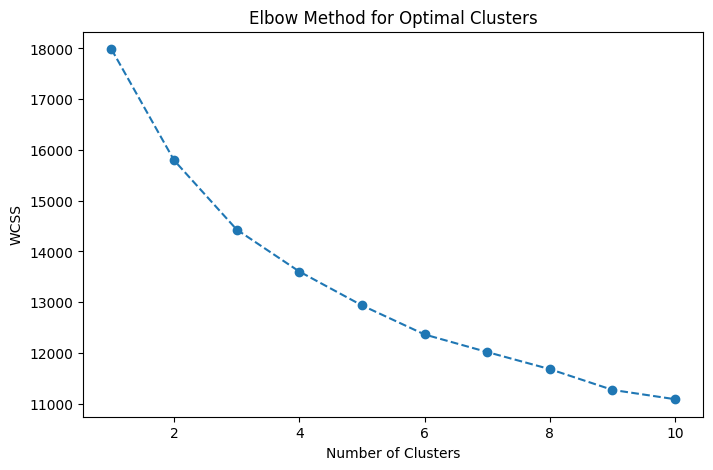

In [177]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()


In [178]:
k = 3  # Based on the elbow method
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(churners_scaled)

In [179]:

# Add the cluster labels to the dataset
churners["Cluster"] = clusters






In [180]:

# Convert back to DataFrame
churners_df = pd.DataFrame(churners, columns=X_train.columns)
churners_df["Cluster"] = clusters

# Check mean values for each cluster
cluster_summary = churners_df.groupby("Cluster").mean()
print(cluster_summary)

         CreditScore        Age    Tenure        Balance  NumOfProducts  \
Cluster                                                                   
0         641.788580  45.016975  4.987654   70338.207299       1.501543   
1         649.196347  44.856925  4.974125  120733.681842       1.462709   
2         651.290909  44.148485  4.693939   74540.730273       1.524242   

         HasCrCard  IsActiveMember  EstimatedSalary  Geography_Germany  \
Cluster                                                                  
0         0.699074        0.368827    103605.778364                0.0   
1         0.706240        0.372907     99037.760776                1.0   
2         0.675758        0.345455    104871.061091                0.0   

         Geography_Spain  Gender_Male  
Cluster                                
0                    0.0     0.430556  
1                    0.0     0.442922  
2                    1.0     0.439394  
